In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score   



/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data


In [4]:

# load data
# I will duplicate the files, just to test 2 differnet models: Random forest and KNeighborsClassifier
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')


# print the first 5 rows of the dataframes
display(train_df.tail())  #column 'survived' 1--> survived, 0--> died
display(test_df.head())




,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.0,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.0,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.0,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.0,1,0.0,1.0,71173.03,0
165033,165033,15732798,Ulyanov,850,France,Male,31.0,1,0.0,1,1.0,0.0,61581.79,1


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


## Key description: 
- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (1 = yes, 0 = no)

##  Review The Data


In [5]:
train_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


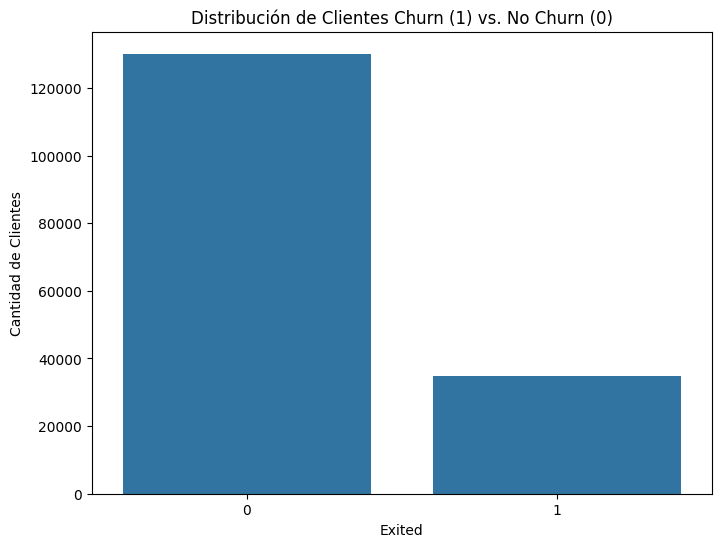

In [6]:
# Graficar la distribución
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='Exited')
plt.title("Distribución de Clientes Churn (1) vs. No Churn (0)")
plt.xlabel("Exited")
plt.ylabel("Cantidad de Clientes")
plt.show()

## Preprocess the Data
- Encode categorical variables.
- Fill missing values if any.

In [7]:
# Encode categorical columns
label_encoder = LabelEncoder()
train_df['Gender'] = label_encoder.fit_transform(train_df['Gender'])
train_df['Geography'] = label_encoder.fit_transform(train_df['Geography'])

# Check for missing values
print(train_df.isnull().sum())
# If any missing values, handle them (e.g., imputation)


id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


## Correlation Matrix
- Calculate and visualize the correlation matrix to identify highly correlated features and relationships with the target.

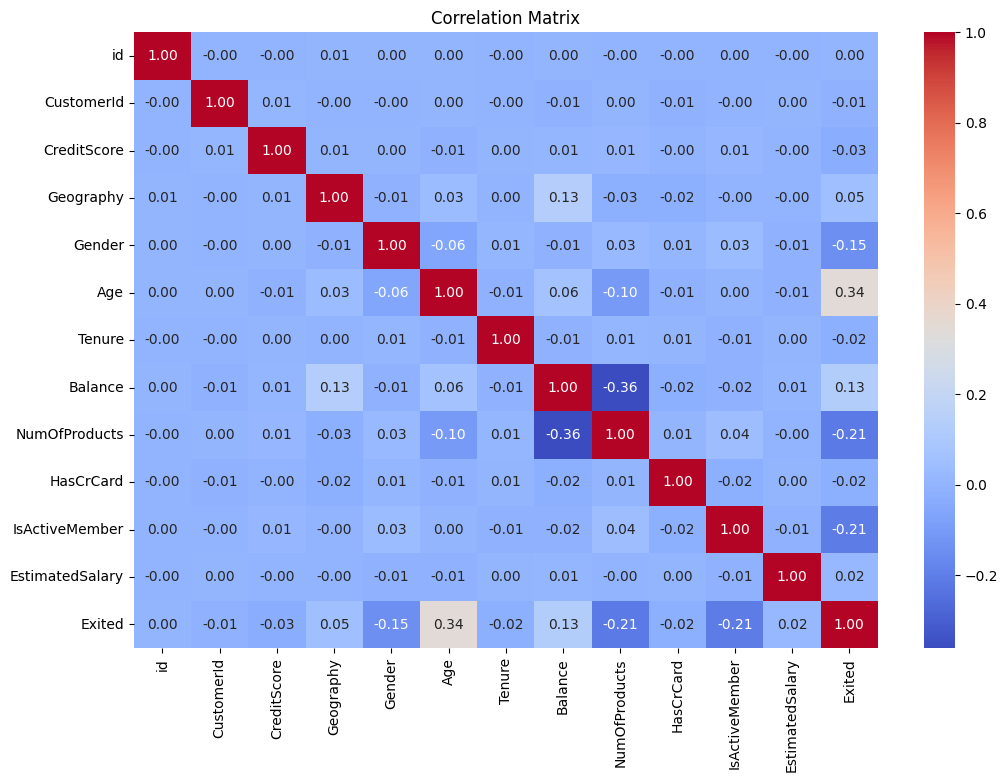

In [8]:
# Calculate correlation matrix, excluding non-numeric columns
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Plot heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Define Features and Target
- Separate the dataset into features (X) and target (y).

In [9]:
# Define X and y
X = train_df.drop(columns=['Exited', 'Surname'])
y = train_df['Exited']

## Feature Importance with Random Forest
- Use a Random Forest model to identify the importance of each feature in predicting churn.



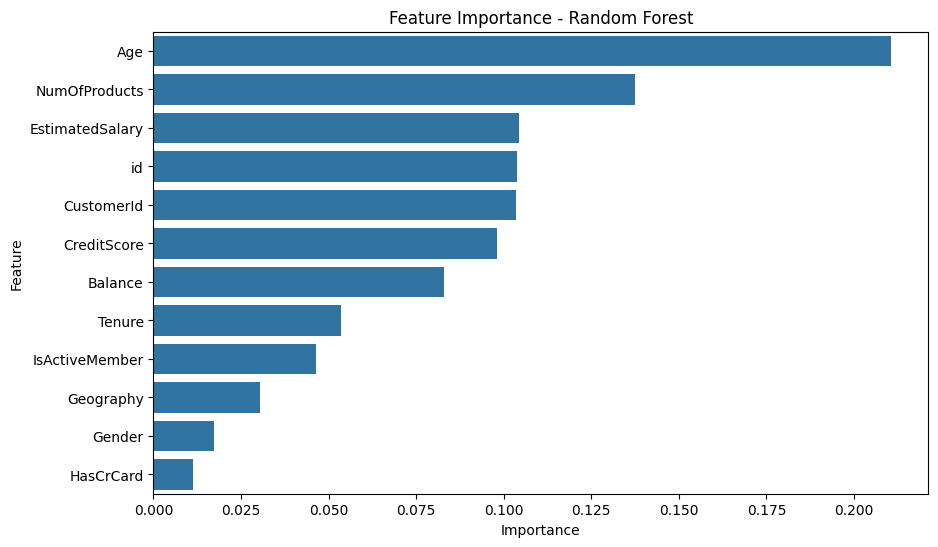

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance - Random Forest")
plt.show()

## Feature Selection with Recursive Feature Elimination (RFE)
- Use RFE to iteratively remove features with the least importance and identify an optimal subset.

In [11]:
# Initialize RFE with the Random Forest model
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", selected_features)

Selected Features by RFE: Index(['id', 'CustomerId', 'Age', 'NumOfProducts', 'EstimatedSalary'], dtype='object')


## Evaluate the Model with Selected Features
- Train the model using only the selected features to see if the performance improves.

In [12]:
# Train and evaluate using all features
rf_model_all = RandomForestClassifier(random_state=42)
rf_model_all.fit(X_train, y_train)

# Predict and evaluate accuracy using all features
y_pred_all = rf_model_all.predict(X_test)
accuracy_all = accuracy_score(y_test, y_pred_all)
print("Model Accuracy with All Features:", accuracy_all)

# Comparison with selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

rf_model_rfe = RandomForestClassifier(random_state=42)
rf_model_rfe.fit(X_train_rfe, y_train)

# Predict and evaluate accuracy using selected features
y_pred_rfe = rf_model_rfe.predict(X_test_rfe)
accuracy_selected = accuracy_score(y_test, y_pred_rfe)
print("Model Accuracy with Selected Features:", accuracy_selected)

Model Accuracy with All Features: 0.861000585728424
Model Accuracy with Selected Features: 0.835390115327907


In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

# Usando todas las características
y_pred_all = rf_model_all.predict(X_test)
y_proba_all = rf_model_all.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva

accuracy_all = accuracy_score(y_test, y_pred_all)
f1_all = f1_score(y_test, y_pred_all)
recall_all = recall_score(y_test, y_pred_all)
precision_all = precision_score(y_test, y_pred_all)
roc_auc_all = roc_auc_score(y_test, y_proba_all)

print("Metrics with All Features:")
print(f"Accuracy: {accuracy_all}")
print(f"F1-Score: {f1_all}")
print(f"Recall: {recall_all}")
print(f"Precision: {precision_all}")
print(f"ROC-AUC: {roc_auc_all}")

# Usando características seleccionadas
y_pred_rfe = rf_model_rfe.predict(X_test_rfe)
y_proba_rfe = rf_model_rfe.predict_proba(X_test_rfe)[:, 1]  # Probabilidad de clase positiva

accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
f1_rfe = f1_score(y_test, y_pred_rfe)
recall_rfe = recall_score(y_test, y_pred_rfe)
precision_rfe = precision_score(y_test, y_pred_rfe)
roc_auc_rfe = roc_auc_score(y_test, y_proba_rfe)

print("\nMetrics with Selected Features:")
print(f"Accuracy: {accuracy_rfe}")
print(f"F1-Score: {f1_rfe}")
print(f"Recall: {recall_rfe}")
print(f"Precision: {precision_rfe}")
print(f"ROC-AUC: {roc_auc_rfe}")

Metrics with All Features:
Accuracy: 0.861000585728424
F1-Score: 0.6153588195841717
Recall: 0.530449026787435
Precision: 0.7326324194836306
ROC-AUC: 0.8787055619608788

Metrics with Selected Features:
Accuracy: 0.835390115327907
F1-Score: 0.5406380340435125
Recall: 0.46213143187512046
Precision: 0.6512764801738186
ROC-AUC: 0.8264800541326626


## Making the predictions using the test file

In [14]:
# Ejemplo: convertir columnas categóricas en dummies
test_df = pd.get_dummies(test_df, columns=['Geography', 'Gender'], drop_first=True)

# Asegurarse de que el conjunto de test tiene las mismas columnas que el conjunto de entrenamiento
missing_cols = set(X_train.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0
test_df = test_df[X_train.columns]  # Ordenar las columnas para que coincidan con X_train
print(test_df.head())
# Realizar las predicciones en el conjunto de test
test_predictions = rf_model_all.predict(test_df)
test_probabilities = rf_model_all.predict_proba(test_df)[:, 1]  # Probabilidades de churn
# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'id': test_df['id'],  # Asegúrate de que esta columna esté en test_df
    'Exited_Prediction': test_predictions,
    'Exited_Probability': test_probabilities
})

# Guardar el DataFrame en un archivo CSV
results_df.to_csv("predicciones_churn.csv", index=False)

print("Predicciones guardadas en predicciones_churn.csv")

       id  CustomerId  CreditScore  Geography  Gender   Age  Tenure  \
0  165034    15773898          586          0       0  23.0       2   
1  165035    15782418          683          0       0  46.0       2   
2  165036    15807120          656          0       0  34.0       7   
3  165037    15808905          681          0       0  36.0       8   
4  165038    15607314          752          0       0  38.0      10   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0       0.00              2        0.0             1.0        160976.75  
1       0.00              1        1.0             0.0         72549.27  
2       0.00              2        1.0             0.0        138882.09  
3       0.00              1        1.0             0.0        113931.57  
4  121263.62              1        1.0             0.0        139431.00  
Predicciones guardadas en predicciones_churn.csv


In [15]:
# Crear un DataFrame con solo el CustomerID y la probabilidad de churn
probability_df = pd.DataFrame({
    'id': test_df['id'],  # Asegúrate de que esta columna esté en test_df
    'Exited_Probability': test_probabilities
})

# Guardar el DataFrame en un archivo CSV
probability_df.to_csv("churn_probabilities.csv", index=False)

print("Archivo con id y probabilidades de churn guardado en churn_probabilities.csv")

Archivo con id y probabilidades de churn guardado en churn_probabilities.csv


## Gain Curve
### The gain curve is a tool to evaluate the effectiveness of your churn prediction model by showing the cumulative percentage of churned customers captured as you intervene on customers with the highest predicted probability of churn. Here’s how to interpret it:

- Starting Point: At 0%, the gain is 0 because no customers have been intervened on yet.

- Initial Percentiles: In the early percentiles (say, top 10-20% of customers), a well-performing model should capture a large portion of the total churned customers. If the curve rises steeply in these early stages, it indicates that your model is effectively ranking high-risk churners near the top.

- Maximum Gain: As you intervene on more customers (moving toward 100%), the cumulative gain approaches 100%, since by the end, you have covered the entire population. However, if your model is effective, you should see a higher percentage of churned customers captured in the earlier stages, with a slower gain in the later stages.

- Benchmark Comparison: In general, a random intervention would result in a linear gain curve, where the percentage of churned customers captured would be directly proportional to the percentage of customers intervened. A model with predictive power will have a curve that rises faster initially and flattens out, demonstrating that you’re capturing a larger portion of churners sooner.

- Decision-Making Insight: The point where the gain curve starts to flatten can help you decide how many customers to focus retention efforts on to maximize effectiveness. For instance, if the curve flattens out at 50%, it suggests that focusing on the top 50% of customers based on churn probability might give you the majority of the benefit.

In summary, a good model's gain curve will show a sharp increase in the first few percentiles, leveling off as more of the population is included. This curve helps you prioritize resources on high-risk customers to maximize retention efforts.

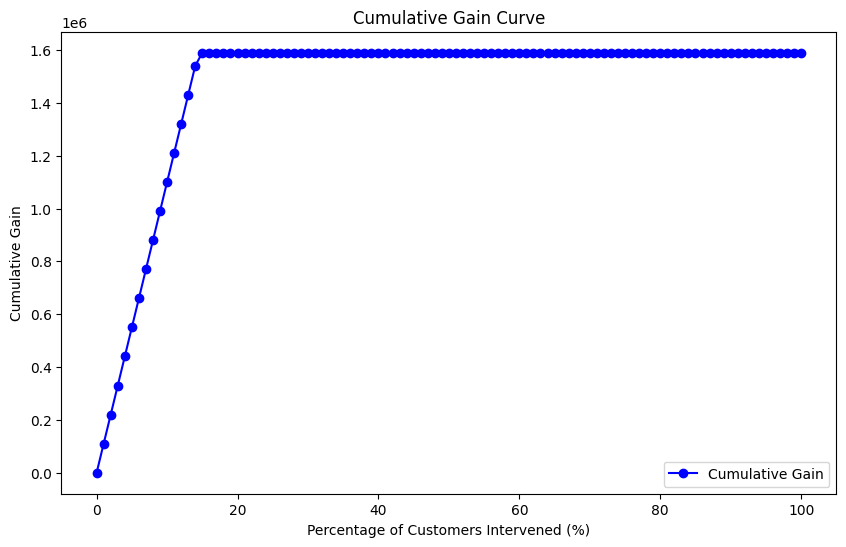

In [20]:
# Definir el valor potencial de cada cliente retenido
customer_value = 100

# Ordenar los clientes en `results_df` por la probabilidad de churn en orden descendente
results_df = results_df.sort_values(by='Exited_Probability', ascending=False).reset_index(drop=True)

# Calcular ganancias acumuladas para los clientes retenidos
results_df['Cumulative_Gain'] = np.cumsum(results_df['Exited_Prediction'] * customer_value)

# Calcular lift acumulado
results_df['Cumulative_Lift'] = np.cumsum(results_df['Exited_Prediction']) / np.arange(1, len(results_df) + 1)

# Dividir en percentiles y calcular la ganancia acumulada en cada percentil
percentiles = np.linspace(0, 1, 101)
# Calculate cumulative gains by percentiles
gain_percentile = []

for p in percentiles:
    index = int(len(results_df) * p)
    
    # Ensure there's data to select
    if index > 0:
        gain_percentile.append(results_df.iloc[:index]['Cumulative_Gain'].iloc[-1])
    else:
        gain_percentile.append(0)  # No gain at 0%

# Plot the gain curve
plt.figure(figsize=(10, 6))
plt.plot(percentiles * 100, gain_percentile, marker='o', color='b', label="Cumulative Gain")
plt.xlabel("Percentage of Customers Intervened (%)")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Curve")
plt.legend()
plt.show()





## Lift Chart Interpretation
The lift curve shows how the lift changes as we intervene in a higher percentage of customers, starting with those who have the highest probability of churn.

Lift values greater than 1 in the initial percentiles indicate that the model is more effectively identifying high-risk customers compared to a random selection.

As we move toward intervening in 100% of customers, the lift should trend toward 1, as the intervention would cover the entire population without distinction.

This analysis is useful for deciding the optimal percentage of customers to focus retention efforts on, maximizing resource effectiveness by targeting customers with a high probability of churn.

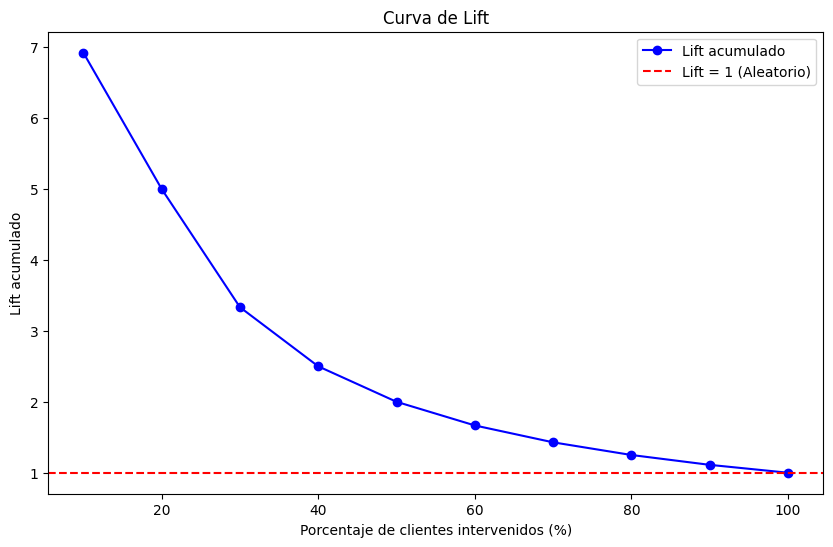

In [19]:
# Calcular la tasa de churn promedio
average_churn_rate = results_df['Exited_Prediction'].mean()

# Ordenar clientes por probabilidad de churn (de mayor a menor)
results_df = results_df.sort_values(by='Exited_Probability', ascending=False).reset_index(drop=True)

# Calcular lift acumulado por percentiles
percentiles = np.linspace(0, 1, 11)  # 0%, 10%, 20%, ..., 100%
lift_percentile = []

for p in percentiles:
    # Seleccionar el top p% de clientes con mayor probabilidad de churn
    index = int(len(results_df) * p)
    selected = results_df.iloc[:index]
    
    # Calcular la tasa de churn en el grupo seleccionado
    churn_rate_selected = selected['Exited_Prediction'].mean()
    
    # Calcular lift para este percentil
    lift = churn_rate_selected / average_churn_rate if average_churn_rate != 0 else 0
    lift_percentile.append(lift)

# Graficar el lift acumulado
plt.figure(figsize=(10, 6))
plt.plot(percentiles * 100, lift_percentile, marker='o', color='b', label="Lift acumulado")
plt.axhline(y=1, color='r', linestyle='--', label="Lift = 1 (Aleatorio)")
plt.xlabel("Porcentaje de clientes intervenidos (%)")
plt.ylabel("Lift acumulado")
plt.title("Curva de Lift")
plt.legend()
plt.show()